In [36]:
import numpy as np
from typing import List 
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [37]:
class Bandit:
    def __init__(self, rvs: callable):
        """Beta(1, 1) is a uniform prior
        Beta is the Conjugate Prior for Bernoulli 
        """
        self.rvs = rvs
        self.alpha = 1 
        self.beta = 1 
        self.N = 0

    def pull(self):
        return self.rvs()

    def update(self, x):
        self.alpha += x
        self.beta += 1 - x 
        self.N += 1
    
    def sample(self):
        return stats.beta(self.alpha, self.beta).rvs()

In [38]:
# Random Variables 
def setup_normal(mu: float = 0.0, sd: float = 1.0) -> callable:
    def normal_rvs():
        return np.random.normal(mu, sd) 
    return normal_rvs


def setup_exponential(m: float, mu: float = 1.0, sd: float = 1.0) -> callable:
    def exp_rvs():
        return stats.expon(loc=mu, scale=sd) + m
    return exp_rvs


def setup_bernoulli(p: float) -> callable:
    def bern_rvs():
        return stats.bernoulli(p).rvs
    return bern_rvs()

In [79]:
def plot_posterior(bandits: Bandit, samples: int):
    x = np.linspace(0.00, 1.0, 200)
    line_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(15, 8))
    plt.title(f"Posterior After {samples} Samples")
    for i, bandit in enumerate(bandits):
        plt.plot(
            x, stats.beta.pdf(x, bandit.alpha, bandit.beta), 'r-', lw=5, alpha=0.6,
            label=f'bandit {i}, win rate: {(bandit.alpha - 1) / bandit.N: .4f}', c=line_colors[i]
            ) 
    plt.legend()


In [82]:
def experiment(num_trials: int = 10000, bandit_skews: List[float] = [0.01, 0.2, 0.7], show_plots: bool = False):
    bandits = [Bandit(setup_bernoulli(skew)) for skew in bandit_skews]
    n_bandits = len(bandits)
    rewards = np.zeros(num_trials)
    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0
    optimal_j = np.argmax(bandit_skews)
    print(f'Optimal bandit: {optimal_j}')

    sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 2000]

    for i in range(num_trials):
        # Thompson Sampling 
        samples = [bandit.sample() for bandit in bandits] 
        j = np.argmax(samples)
        if j == optimal_j:
            num_optimal += 1
        # Plot the posterios
        if i in sample_points:
            plot_posterior(bandits, i)

        # Pull the arm for the bandit choosen
        x = bandits[j].pull()
        # Update the rewards log
        rewards[i] = x
        # Update the distribution for the chosen bandit
        bandits[j].update(x)

    # Print the mean estimates for each bandit
    #for i, bandit in enumerate(bandits):
    #    print(f'Mean estimate of bandit {i}: {bandit.:.4f}')
    
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(num_trials) + 1)

    if show_plots:
        # Print total reward
        print(f"Total reward earned: {rewards.sum()}")
        print(f"Overall win rate: {rewards.sum() / num_trials}")
        print(f"Num_times_explored: {num_times_explored}")
        print(f"Num_times_exploited: {num_times_exploited}")
        print(f"Num times selected optimal bandit: {num_optimal}")
        print("Num times selected each bandit:", [b.N for b in bandits]) 
        
        # plot the results
        plt.figure(figsize=(15, 8))
        plt.title("Win Rate Over Time (x-axis log scale)")
        plt.plot(win_rates)
        for skew in bandit_skews:
            plt.plot(np.ones(num_trials) * skew)
        plt.plot(np.ones(num_trials) * np.max(bandit_skews))
        plt.xscale('log')
        plt.show()
    return win_rates

Optimal bandit: 2
Total reward earned: 6965.0
Overall win rate: 0.6965
Num_times_explored: 0
Num_times_exploited: 0
Num times selected optimal bandit: 9982
Num times selected each bandit: [7, 11, 9982]


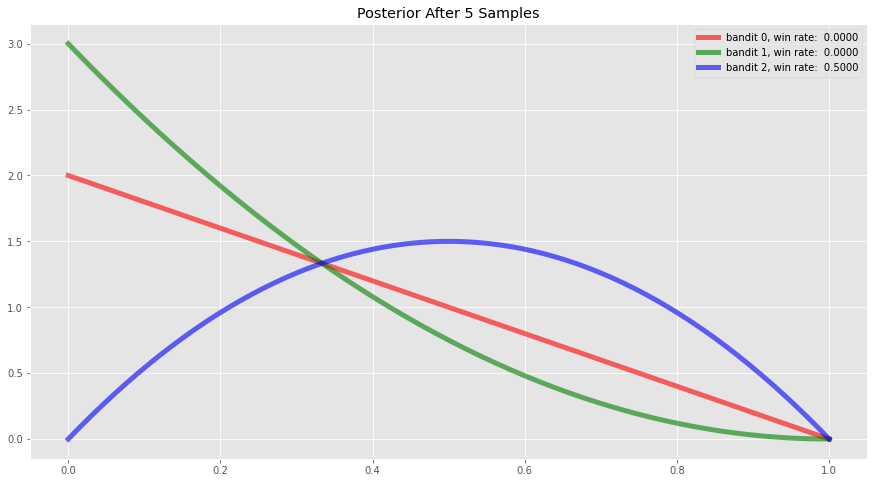

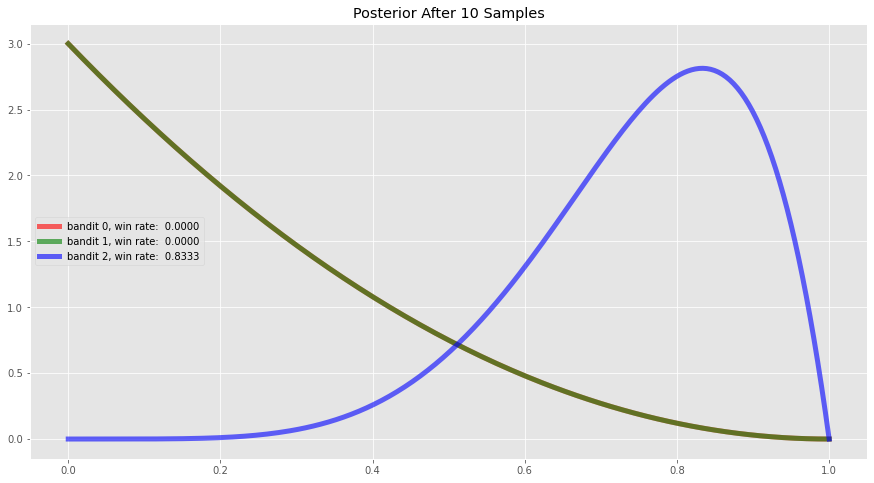

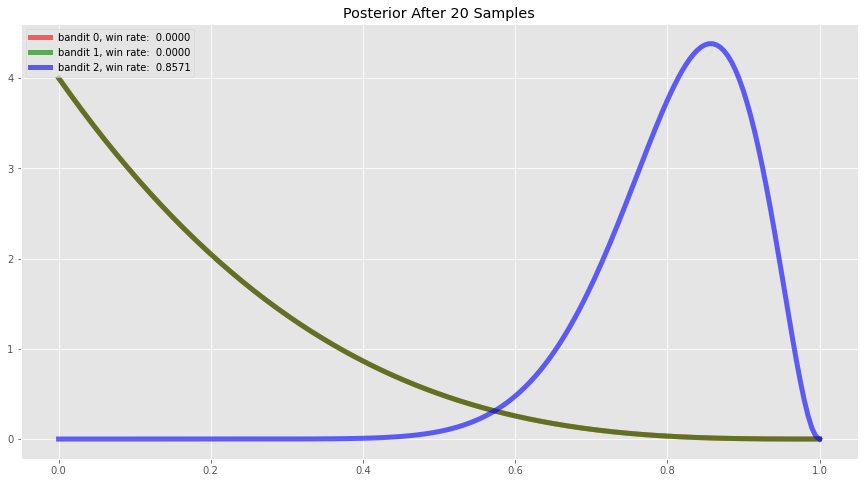

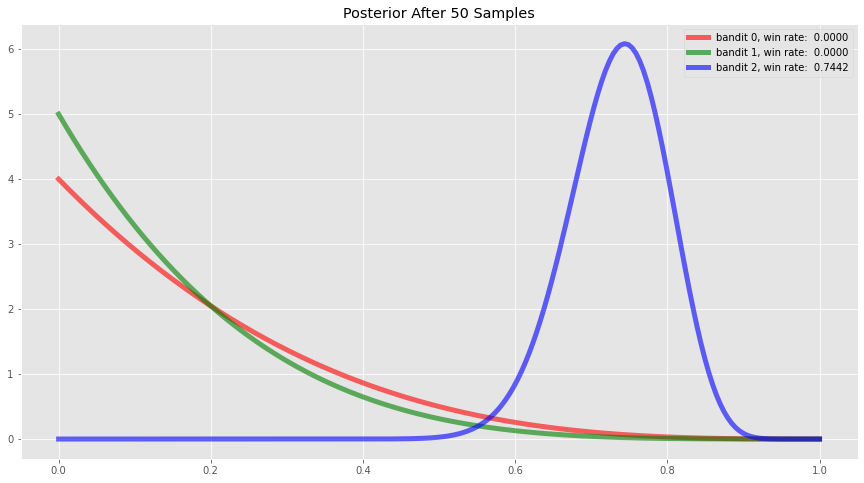

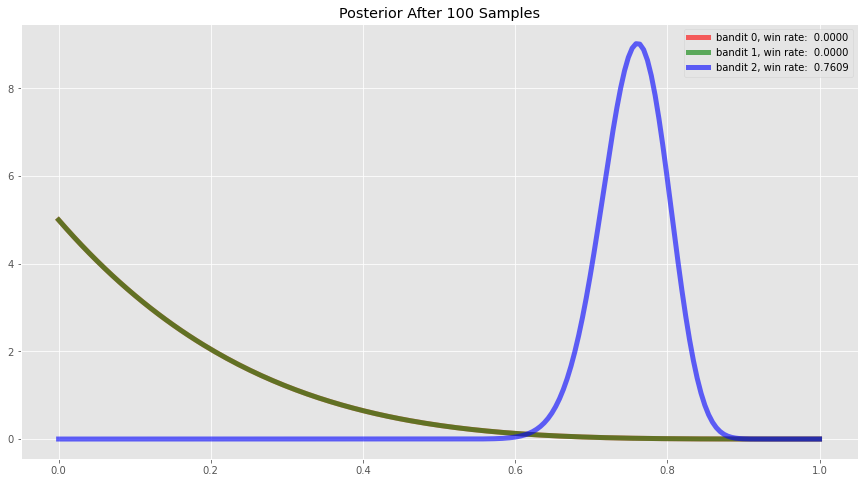

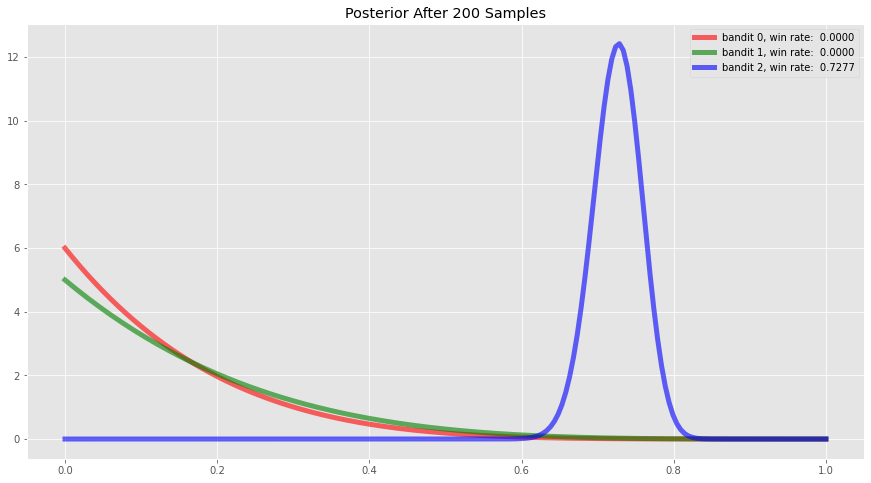

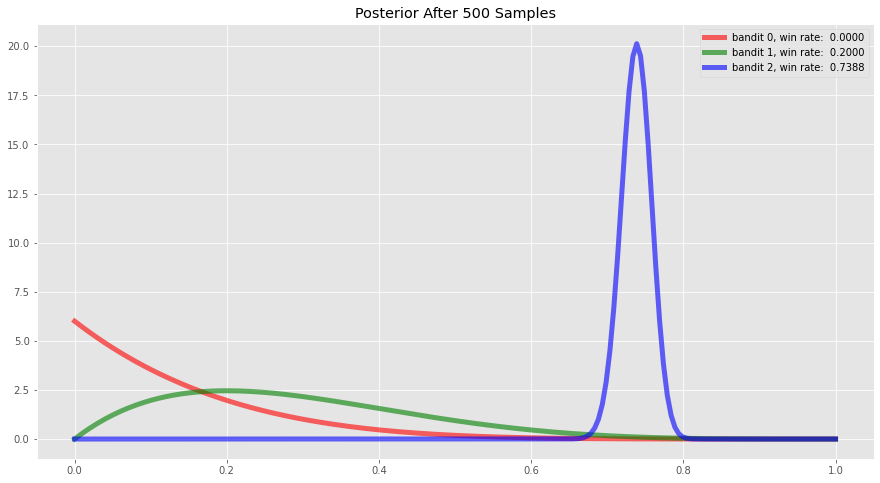

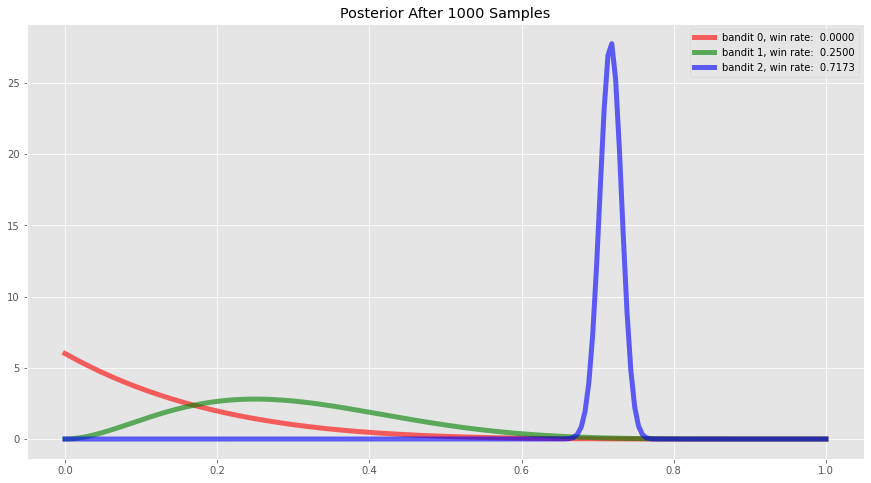

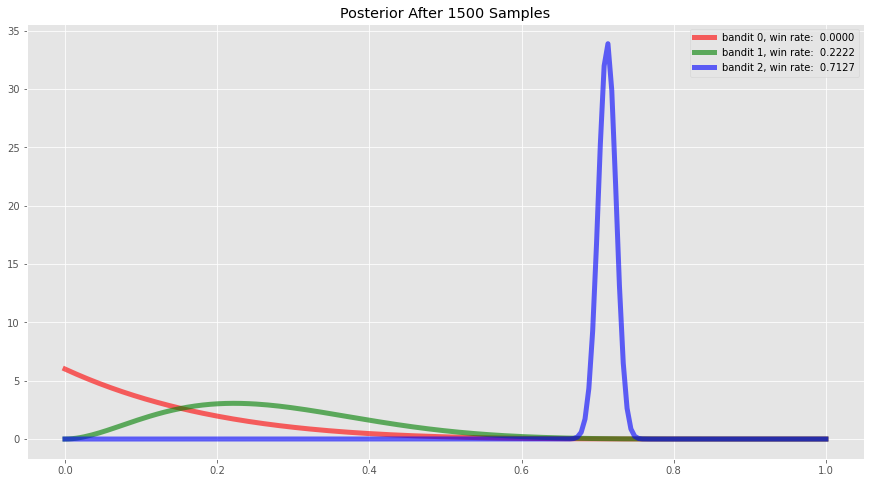

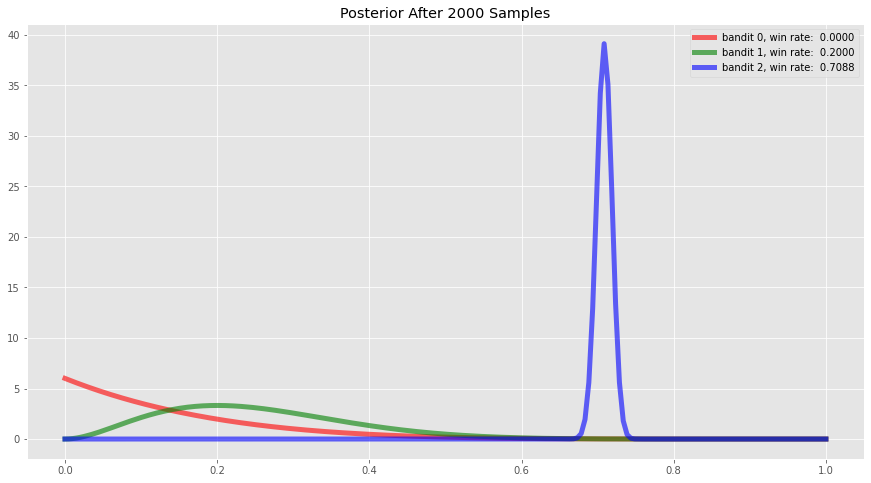

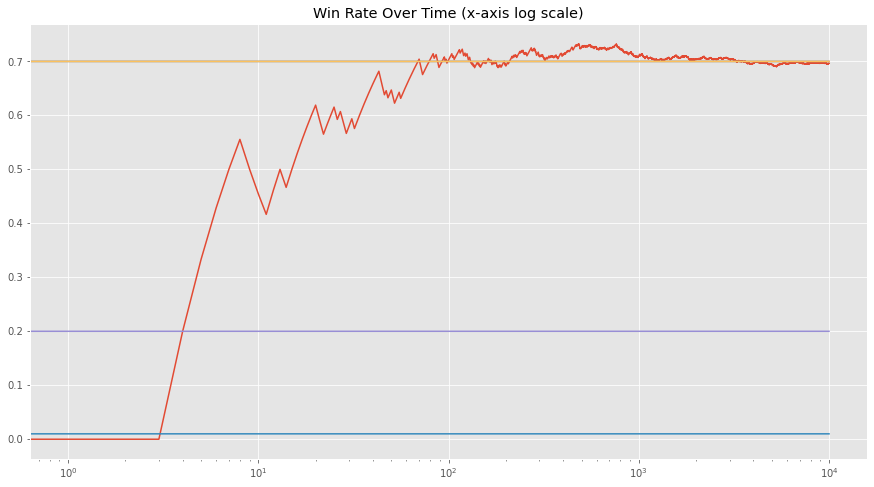

array([0.        , 0.        , 0.        , ..., 0.69643929, 0.69646965,
       0.6965    ])

In [83]:
experiment(show_plots=True)

In [50]:
c_10 = experiment(eps=0.1)
c_05 = experiment(eps=0.05)
c_01 = experiment(eps=0.01)

plt.figure(figsize=(15, 8))
plt.plot(c_10, label="eps=0.10")
plt.plot(c_05, label="eps=0.05")
plt.plot(c_01, label="eps=0.01")
plt.legend()
plt.xscale('log')
plt.show() 


plt.figure(figsize=(15, 8))
plt.plot(c_10, label="eps=0.10")
plt.plot(c_05, label="eps=0.05")
plt.plot(c_01, label="eps=0.01")
plt.legend()
plt.show() 


TypeError: ignored